In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../helper_functions')
sys.path.append('../objects')
sys.path.append('../../machineLearning/helpers/')
# sys.path.append('/home/ssd2tb/dturcu/electric_fish_processed_data/')

import copy
import time
import dill
import numpy as np
import pandas as pd
import h5py
import scipy.io as io
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import plotly.graph_objects as go
from tabulate import tabulate
import random


In [3]:
from prefixes import remove_prefix, add_prefix
from conversions import rho24sig, convert2mainSI

from ElectricObject import ElectricObject

from Worm import Worm
from Worm_SmallSpherical import SmallSphericalWorm

from Fish import Fish
from FishGeneration import FishGeneration
from Fish_IceCreamCone import IceCreamConeFish
from Fish_Capsule import CapsuleFish

from Boundaries import *
from Aquarium import Aquarium
from Aquarium_SinglePlane import SinglePlaneAquarium

from load_data import load_data_full

from assertion_tests import run_tests

from find_EI_ids import find_EI_ids, find_base_ids
run_tests()

'Success!'

## Load the processed data

In [4]:
# file_name = '../data/processed/data_220607_Large_dataset_with_receptors_responses'  # extensions are .pkl and .hdf5 for the two files storing the dataset
# file_name = '../data/processed/data_220623_Small_dataset_Lateral_boundary_Receptors_responses'  # extensions are .pkl and .hdf5 for the two files storing the dataset
# file_name = '../data/processed/data_220623_Single_receptor_Three_boundaries_Tail_positions_effects_on_DLZ'  # extensions are .pkl and .hdf5 for the two files storing the dataset
# file_name = '../data/processed/data_220610_Large_dataset_with_receptors_responses'
file_name = '/home/ssd2tb/dturcu/electric_fish_processed_data/data_220610_Large_dataset_with_receptors_responses'
# file_name = '/home/ssd2tb/dturcu/electric_fish_processed_data/data_230315_Large_dataset_with_receptors_responses_REMAKE'
# file_name = '/home/ssd2tb/dturcu/electric_fish_processed_data/data_230315_YES_manyObjects_NO_boundaries_NO_tail_ONE_conductivity_REMAKE'
use_torch = False
find_base_id_for_each_EI=False

[properties_dict,
properties_ids_base, properties_ids_pert,
base_EI, base_LEODs, pert_EI, pert_LEODs,
# aquarium properties
water_conductivities, boundary_normals, boundary_displacements,
# fish properties
tail_lateral_angle, tail_dor_ven_angle, tail_location_percent, fish_yaw, fish_pitch, fish_roll,
# worm properties
resistances, capacitances, worm_radii, worm_xs, worm_ys, worm_zs,
# statistics of receptor responses
receptors_avg, receptors_std,
# objects used in simulations
aqua_objs, fish_objs, worm_objs] = \
    load_data_full(file_name=file_name, use_torch=use_torch, find_base_id_for_each_EI=find_base_id_for_each_EI)
    
print(properties_ids_base.shape)
print(properties_ids_pert.shape)

Data loaded.
Data extracted.
     Component 0: water conductivity
     Component 1: boundary normals
     Component 2: boundary displacements
     Component 3: tail lateral angle
     Component 4: tail dor ven angle
     Component 5: tail location percent
     Component 6: fish yaw
     Component 7: fish pitch
     Component 8: fish roll
     Component 9: resistances
     Component 10: capacitances
     Component 11: worm radii
     Component 12: worm xs
     Component 13: worm ys
     Component 14: worm zs
     Component 15: pert EI
     Component 16: base EI
(390, 10)
(13162500, 17)


## Select a particular experiment to visualize

In [5]:
names = ['water_conductivities', 'boundary_normals', 'boundary_displacements', 'tail_lateral_angle',  'tail_dor_ven_angle', 'tail_location_percent', 'fish_yaw', 'fish_pitch', 'fish_roll', 'resistances', 'capacitances', 'worm_radii', 'worm_xs', 'worm_ys', 'worm_zs',]
variables = [
     [f'ID {i}: {x:.2f} S/m' for i, x in enumerate(water_conductivities)], 
     [f'ID {i}: {x}' for i, x in enumerate(boundary_normals)], 
     [[f'{i}: {abs(d)*1000 if abs(d) < 1 else np.inf:.0f}' for i, d in enumerate(b)] for b in boundary_displacements],
     [f'ID {i}: {x}' for i, x in enumerate(tail_lateral_angle)], 
     [f'ID {i}: {x}' for i, x in enumerate(tail_dor_ven_angle)],
     [f'ID {i}: {x}' for i, x in enumerate(tail_location_percent)],
     [f'ID {i}: {x:.2f} deg' for i, x in enumerate(fish_yaw)],
     [f'ID {i}: {x:.2f} deg' for i, x in enumerate(fish_pitch)],
     [f'ID {i}: {x:.2f} deg' for i, x in enumerate(fish_roll)],
     [f'ID {i}: {x/1e3:.1f} *1e3 Ohm' for i, x in enumerate(resistances)],
     [f'ID {i}: {x*1e9:.1f} *1e-9 F ' for i, x in enumerate(capacitances)],
     [f'ID {i}: {x*1000:.2f} mm' for i, x in enumerate(worm_radii)],
     [f'ID {i}: {x*1000:.2f} mm' for i, x in enumerate(worm_xs)],
     [f'ID {i}: {x*1000:.2f} mm' for i, x in enumerate(worm_ys)],
     [f'ID {i}: {x*1000:.2f} mm' for i, x in enumerate(worm_zs)],
    ]
max_len = np.max([len(x) for x in variables])
variables = [vrbls + [None]*(max_len-len(vrbls)) for vrbls in variables]
variables = [list(x) for x in zip(*variables)]


In [6]:
f = open('table.txt', 'w')
print(tabulate([names] + variables, headers='firstrow', tablefmt='grid'), file=f)

### Select IDs

In [7]:
# aquarium properties
water_conductivities_id   = 0
boundary_normals_id       = 0
boundary_displacements_id = 0  # 3  ###
# fish properties
tail_lateral_angle_id    = 0  # 0  ###
tail_dor_ven_angle_id    = 0
tail_location_percent_id = 0
fish_yaw_id              = 0
fish_pitch_id            = 0
fish_roll_id             = 0
# worm properties
resistances_id  = 15
capacitances_id = 15 
worm_radii_id   = 2
worm_xs_id      = 0
worm_ys_id      = 0
worm_zs_id      = 0

print('Selected experiment properties:')
print(f'     water_conductivity:        {water_conductivities[water_conductivities_id]:.2f} S/m')
print(f'     boundary_normals:          {boundary_normals[boundary_normals_id]}')
print(f'     boundary_displacements:    {np.inf if np.abs(boundary_displacements[boundary_normals_id][boundary_displacements_id]) > 1 else boundary_displacements[boundary_normals_id][boundary_displacements_id]*1e3:.1f} mm')
print(f'     tail_lateral_angle:    {tail_lateral_angle[tail_lateral_angle_id]} deg')
print(f'     tail_dor_ven_angle:    {tail_dor_ven_angle[tail_dor_ven_angle_id]} deg')
print(f'     tail_location_percent: {tail_location_percent[tail_location_percent_id]}')
print(f'     fish_yaw:              {fish_yaw[fish_yaw_id]} deg')
print(f'     fish_pitch:            {fish_pitch[fish_pitch_id]} deg')
print(f'     fish_roll:             {fish_roll[fish_roll_id]} deg')
print(f'     resistances:  {resistances[resistances_id]/1e3:.1f} *1e3 Ohm')
print(f'     capacitances: {capacitances[capacitances_id]*1e9:.1f} *1e-9 F')
print(f'     worm_radii:   {worm_radii[worm_radii_id]*1000:.0f} mm')
print(f'     worm_xs:      {worm_xs[worm_xs_id]*1000:.0f} mm')
print(f'     worm_ys:      {worm_ys[worm_ys_id]*1000:.0f} mm')
print(f'     worm_zs:      {worm_zs[worm_zs_id]*1000:.0f} mm')

base_EI_id, pert_EI_id = find_EI_ids(properties_ids_base,properties_ids_pert,properties_dict,water_conductivities_id,boundary_normals_id,boundary_displacements_id,tail_lateral_angle_id,tail_dor_ven_angle_id,tail_location_percent_id,fish_yaw_id,fish_pitch_id,fish_roll_id,resistances_id,capacitances_id,worm_radii_id,worm_xs_id,worm_ys_id,worm_zs_id,
        default_boundary_displacement_id=0, 
        default_tail_lateral_angle_id=len(tail_lateral_angle)//2, 
        default_tail_dor_ven_angle_id=0, default_yaw_id=0, default_pitch_id=0, default_roll_id=0,
        cancel_boundary=True,
        cancel_tail=True,
        cancel_rotation=False)

Selected experiment properties:
     water_conductivity:        0.01 S/m
     boundary_normals:          [0, 0, 1]
     boundary_displacements:    inf mm
     tail_lateral_angle:    [-60.0] deg
     tail_dor_ven_angle:    [0] deg
     tail_location_percent: [60]
     fish_yaw:              0 deg
     fish_pitch:            0 deg
     fish_roll:             0 deg
     resistances:  7.5 *1e3 Ohm
     capacitances: 7.5 *1e-9 F
     worm_radii:   10 mm
     worm_xs:      5 mm
     worm_ys:      17 mm
     worm_zs:      0 mm
Base:  [0]  | Pert:  [21096]


## Visualize 3D EI

In [ ]:
zone = 0
# intensity = (pert_EI[pert_EI_id,:,zone] - base_EI[base_EI_id,:,zone]) / receptors_std[:,zone]
# intensity = pert_EI[pert_EI_id,:,zone] / base_EI[base_EI_id,:,zone] - 1
# intensity = base_EI[76,:,zone] - base_EI[4,:,zone]
intensity = pert_EI[pert_EI_id,:,zone] - base_EI[base_EI_id,:,zone]
# intensity = base_EI[base_EI_id,:,zone]
# intensity = pert_EI[pert_EI_id,:,zone]
intensity = pert_EI[pert_EI_id,:,zone] - base_EI[4,:,zone]
# intensity = (base_EI[base_EI_id,:,zone] - base_EI.mean(0)[:,zone]) / base_EI.std(0)[:,zone]  # receptors_std[:,zone]
# intensity = receptors_avg[:,zone]  # base_EI.std(0)[:,zone]
fish_objs[tail_lateral_angle_id].visualize_scatter(intensity=intensity, show_normals=2, show_point_currents=3, marker_alpha=1,
                                                        fig_width=1300, fig_height=400)
print()

In [ ]:
rand_ids = np.random.permutation(properties_ids_pert.shape[0])[:10]

temp_base_ids = find_base_ids(
    properties_ids_base,
    properties_ids_pert[rand_ids],
    properties_dict,
    cancel_boundary=True,
    cancel_tail=True,
    cancel_rotation=True,
    default_tail_lateral_angle_id=len(tail_lateral_angle)//2,
)

In [ ]:
zone = 0
select_id = 4
intensity = pert_EI[rand_ids[select_id],:,zone] - base_EI[temp_base_ids[select_id],:,zone]
fish_objs[properties_ids_pert[rand_ids[select_id],properties_dict['tail_lateral_angle']]].visualize_scatter(intensity=intensity, show_normals=2, show_point_currents=3, marker_alpha=1,
                                                        fig_width=1300, fig_height=400)
print()

## Visualize 2D EI

In [ ]:
zones = ['MZ', 'DLZ']
receptors = fish_objs[0].get_receptors_locations().copy()
receptors[receptors[:,1]<0, 2] = fish_objs[0].get_vertical_semi_axis() * 2.2 - receptors[receptors[:,1]<0, 2]
receptors = receptors[:,[0,2]]
receptors[:,0] = -receptors[:,0]

for wc_id in range(len(water_conductivities)):
    wc = f'{water_conductivities[wc_id]:.2f}_Spm'.replace('.','p')
    for res_id in [5,15]:  # range(len(resistances)):
        res = f'{resistances[res_id]/1e3:.1f}e3_Ohm'.replace('.','p')
        for cap_id in [5,15]:  # range(len(capacitances)):
            cap = f'{capacitances[cap_id]*1e9:.1f}e-9_F'.replace('.','p')
            for wrad_id in [0, 2]:  # range(len(worm_radii)):
                wrad = f'{worm_radii[wrad_id]*1000:.0f}_mm'
                for wx_id in [1]:  # range(len(worm_xs)):
                    wx = f'{worm_xs[wx_id]*1000:.0f}_mm'
                    for wy_id in [0]:  # range(len(worm_ys)):
                        wy = f'{worm_ys[wy_id]*1000:.0f}_mm'
                        for wz_id in [0]:  # range(len(worm_zs)):
                            wz = f'{worm_zs[wz_id]*1000:.0f}_mm'
                            for zn_id in range(len(zones)):
                                zn = zones[zn_id]
                                f = plt.figure(figsize=(12*len(tail_lateral_angle), 8*len(boundary_displacements[0])))
                                plt.title(f'Zone {zn}, Water conductivity {wc}, Resistance {res}, Capacitance {cap}, Radius {wrad}, X {wx}, Y {wy}, Z {wz}\n\n', fontsize=45)
                                plt.box(False)
                                plt.xticks([])
                                plt.yticks([])
                                subs = []
                                for bd_id in range(len(boundary_displacements[0])):
                                    bd = boundary_displacements[0][bd_id]
                                    for tla_id in range(len(tail_lateral_angle)):
                                        tla = tail_lateral_angle[tla_id]
                                                            
                                        currents = fish_objs[tla_id].get_point_currents_location()[:,:2].copy()
                                        currents[:,1] = -currents[:,1]
                                        currents[:,1] += fish_objs[tla_id].get_vertical_semi_axis() * 1.1
                                        currents[:,0] = -currents[:,0]

                                        base_EI_id, pert_EI_id = find_EI_ids(properties_ids_base, properties_ids_pert, properties_dict,
                                                wc_id, 0, bd_id, tla_id, 0, 0, 0, 0, 0, res_id, cap_id, wrad_id, wx_id, wy_id, wz_id,
                                                default_boundary_displacement_id=0, default_tail_lateral_angle_id=6, default_tail_dor_ven_angle_id=0, default_yaw_id=0, default_pitch_id=0, default_roll_id=0,
                                                cancel_boundary=False,
                                                cancel_tail=False,
                                                cancel_rotation=False)

                                        # intensity = pert_EI[pert_EI_id,:,zn_id] / base_EI[base_EI_id,:,zn_id] - 1
                                        intensity = pert_EI[pert_EI_id,:,zn_id] - base_EI[base_EI_id,:,zn_id]
                                        intensity_range = np.max(np.abs(intensity))
                                        
                                        sub = f.add_subplot(len(boundary_displacements[0]), len(tail_lateral_angle), 
                                                            1 + tla_id + bd_id * len(tail_lateral_angle))
                                        sctr = sub.scatter(*receptors.T, c=intensity, marker='s', s=80, cmap='seismic', vmin=-intensity_range, vmax=intensity_range)
                                        sub.plot(*currents.T, c='k')
                                        if bd_id == 0:
                                            sub.set_title(f'Tail Angle {tla[0]:.0f} deg', fontsize=30)
                                        if tla_id == 0:
                                            sub.set_ylabel(f'Boundary Distance {np.inf if np.abs(bd) > 1 else np.abs(bd)*1e3:.0f} mm', fontsize=30)
                                        sub.set_xticks([])
                                        sub.set_yticks([])
                                        sub.spines['top'].set_visible(False)
                                        sub.spines['right'].set_visible(False)
                                        sub.spines['bottom'].set_visible(False)
                                        sub.spines['left'].set_visible(False)
                                        # sub.axis=('equal')
                                        sub.set_facecolor('grey')
                                        sub.set_xlim(np.array([-0.01,0.12]))
                                        sub.set_ylim(fish_objs[tla_id].get_vertical_semi_axis() * np.array([1.1-3, 1.1+3]))
                                        subs.append(sub)
                                        clrbr = f.colorbar(sctr, orientation='vertical')
                                        clrbr.set_ticks([-round(intensity_range), 0, round(intensity_range)])
                                        clrbr.ax.set_yticklabels([-round(intensity_range), 0, round(intensity_range)], rotation=-90)
                                        clrbr.ax.tick_params(labelsize=30)

                                plt.savefig(f'figures/Zone_{zn}__WaterConductivity_{wc}__Resistance_{res}__Capacitance_{cap}__Radius_{wrad}__X_{wx}__Y_{wy}__Z_{wz}.png',
                                            facecolor=(1,1,1,1))
                                plt.close()


#### Plot figure for lateral boundaries

In [ ]:
zones = ['MZ', 'DLZ']
receptors = fish_objs[0].get_receptors_locations().copy()
receptors[receptors[:,1]<0, 2] = fish_objs[0].get_vertical_semi_axis() * 2.2 - receptors[receptors[:,1]<0, 2]
receptors = receptors[:,[0,2]]
receptors[:,0] = -receptors[:,0]

for wc_id in range(len(water_conductivities)):
    wc = f'{water_conductivities[wc_id]:.2f}_Spm'.replace('.','p')
    for bound_n_id in range(len(boundary_normals)):
        bound_n = 'ipsilateral' if boundary_normals[bound_n_id][1] < 0 else 'contralateral'
        for res_id in [0]:  # range(len(resistances)):
            res = f'{resistances[res_id]/1e3:.1f}e3_Ohm'.replace('.','p')
            for cap_id in [0]:  # range(len(capacitances)):
                cap = f'{capacitances[cap_id]*1e9:.1f}e-9_F'.replace('.','p')
                for wrad_id in [0]:  # range(len(worm_radii)):
                    wrad = f'{worm_radii[wrad_id]*1000:.0f}_mm'
                    for wx_id in [0]:  # range(len(worm_xs)):
                        wx = f'{worm_xs[wx_id]*1000:.0f}_mm'
                        for wy_id in [0]:  # range(len(worm_ys)):
                            wy = f'{worm_ys[wy_id]*1000:.0f}_mm'
                            for wz_id in [0]:  # range(len(worm_zs)):
                                wz = f'{worm_zs[wz_id]*1000:.0f}_mm'
                                for zn_id in range(len(zones)):
                                    zn = zones[zn_id]
                                    f = plt.figure(figsize=(12*len(tail_lateral_angle), 8*len(boundary_displacements[bound_n_id])))
                                    plt.title(f'Zone {zn}, Water conductivity {wc}, Boundary {bound_n} Resistance {res}, Capacitance {cap}, Radius {wrad}, X {wx}, Y {wy}, Z {wz}\n\n', fontsize=45)
                                    plt.box(False)
                                    plt.xticks([])
                                    plt.yticks([])
                                    subs = []
                                    for bd_id in range(len(boundary_displacements[bound_n_id])):
                                        bd = boundary_displacements[bound_n_id][bd_id]
                                        for tla_id in range(len(tail_lateral_angle)):
                                            tla = tail_lateral_angle[tla_id]
                                                                
                                            currents = fish_objs[tla_id].get_point_currents_location()[:,:2].copy()
                                            currents[:,1] = -currents[:,1]
                                            currents[:,1] += fish_objs[tla_id].get_vertical_semi_axis() * 1.1
                                            currents[:,0] = -currents[:,0]

                                            base_EI_id, pert_EI_id = find_EI_ids(properties_ids_base, properties_ids_pert, properties_dict,
                                                    wc_id, bound_n_id, bd_id, tla_id, 0, 0, 0, 0, 0, res_id, cap_id, wrad_id, wx_id, wy_id, wz_id,
                                                    default_boundary_displacement_id=0, default_tail_lateral_angle_id=6, default_tail_dor_ven_angle_id=0, default_yaw_id=0, default_pitch_id=0, default_roll_id=0,
                                                    cancel_boundary=False,
                                                    cancel_tail=False,
                                                    cancel_rotation=False)

                                            # intensity = pert_EI[pert_EI_id,:,zn_id] / base_EI[base_EI_id,:,zn_id] - 1
                                            intensity = pert_EI[pert_EI_id,:,zn_id] - base_EI[base_EI_id,:,zn_id]
                                            intensity_range = np.max(np.abs(intensity))
                                            
                                            sub = f.add_subplot(len(boundary_displacements[bound_n_id]), len(tail_lateral_angle), 
                                                                1 + tla_id + bd_id * len(tail_lateral_angle))
                                            sctr = sub.scatter(*receptors.T, c=intensity, marker='s', s=80, cmap='seismic', vmin=-intensity_range, vmax=intensity_range)
                                            sub.plot(*currents.T, c='k')
                                            if bd_id == 0:
                                                sub.set_title(f'Tail Angle {tla[0]:.0f} deg', fontsize=30)
                                            if tla_id == 0:
                                                sub.set_ylabel(f'Boundary Distance {np.inf if np.abs(bd) > 1 else np.abs(bd)*1e3:.0f} mm', fontsize=30)
                                            sub.set_xticks([])
                                            sub.set_yticks([])
                                            sub.spines['top'].set_visible(False)
                                            sub.spines['right'].set_visible(False)
                                            sub.spines['bottom'].set_visible(False)
                                            sub.spines['left'].set_visible(False)
                                            # sub.axis=('equal')
                                            sub.set_facecolor('grey')
                                            sub.set_xlim(np.array([-0.01,0.12]))
                                            sub.set_ylim(fish_objs[tla_id].get_vertical_semi_axis() * np.array([1.1-3, 1.1+3]))
                                            subs.append(sub)
                                            clrbr = f.colorbar(sctr, orientation='vertical')
                                            clrbr.set_ticks([-round(intensity_range), 0, round(intensity_range)])
                                            clrbr.ax.set_yticklabels([-round(intensity_range), 0, round(intensity_range)], rotation=-90)
                                            clrbr.ax.tick_params(labelsize=30)
                                            
                                    plt.savefig(f'figures_lateral_boundary/Zone_{zn}__WaterConductivity_{wc}__Boundary_{bound_n}__Resistance_{res}__Capacitance_{cap}__Radius_{wrad}__X_{wx}__Y_{wy}__Z_{wz}.png',
                                                facecolor=(1,1,1,1))
                                    plt.close()


## Plot LEODs as function of tail position and boundary displacement

In [ ]:
for wc_id in range(len(water_conductivities)):
    wc = f'{water_conductivities[wc_id]:.2f}_Spm'.replace('.','p')
    for res_id in [0]:  # range(len(resistances)):
        res = f'{resistances[res_id]/1e3:.1f}e3_Ohm'.replace('.','p')
        for cap_id in [0]:  # range(len(capacitances)):
            cap = f'{capacitances[cap_id]*1e9:.1f}e-9_F'.replace('.','p')
            for wrad_id in [0]:  # range(len(worm_radii)):
                wrad = f'{worm_radii[wrad_id]*1000:.0f}_mm'
                for wx_id in [0]:  # range(len(worm_xs)):
                    wx = f'{worm_xs[wx_id]*1000:.0f}_mm'
                    for wy_id in [0]:  # range(len(worm_ys)):
                        wy = f'{worm_ys[wy_id]*1000:.0f}_mm'
                        for wz_id in [0]:  # range(len(worm_zs)):
                            wz = f'{worm_zs[wz_id]*1000:.0f}_mm'
                            f = plt.figure(figsize=(36*len(boundary_normals), 8*len(boundary_displacements[0])))
                            plt.title(f'Water conductivity {wc}, Resistance {res}, Capacitance {cap}, Radius {wrad}, X {wx}, Y {wy}, Z {wz}\n\n', fontsize=65)
                            plt.box(False)
                            plt.xticks([])
                            plt.yticks([])
                            for bound_n_id in range(len(boundary_normals)):
                                if boundary_normals[bound_n_id][1] < -0.5:
                                    bound_n = 'ipsilateral' 
                                elif boundary_normals[bound_n_id][1] > 0.5:
                                    bound_n = 'contralateral'
                                else:
                                    bound_n = 'bottom'
                                    
                                # base_EI_id_normalization, pert_EI_id_normalization = find_EI_ids(properties_ids_base, properties_ids_pert, properties_dict,
                                #             wc_id, bound_n_id, 0, 12, 0, 0, 0, 0, 0, res_id, cap_id, wrad_id, wx_id, wy_id, wz_id,
                                #             default_boundary_displacement_id=0, default_tail_lateral_angle_id=12, default_tail_dor_ven_angle_id=0, default_yaw_id=0, default_pitch_id=0, default_roll_id=0,
                                #             cancel_boundary=False,
                                #             cancel_tail=False,
                                #             cancel_rotation=False)
                                # LEOD_to_plot_normalization = (pert_LEODs[pert_EI_id_normalization] - base_LEODs[base_EI_id_normalization]).T

                                for bd_id in range(len(boundary_displacements[bound_n_id])):
                                    bd = boundary_displacements[bound_n_id][bd_id]
                                    sub = f.add_subplot(len(boundary_displacements[bound_n_id]), len(boundary_normals), 
                                                        1 + bound_n_id + bd_id * len(boundary_normals))

                                    for tla_id in range(len(tail_lateral_angle)):
                                        tla = tail_lateral_angle[tla_id]

                                        base_EI_id, pert_EI_id = find_EI_ids(properties_ids_base, properties_ids_pert, properties_dict,
                                                wc_id, bound_n_id, bd_id, tla_id, 0, 0, 0, 0, 0, res_id, cap_id, wrad_id, wx_id, wy_id, wz_id,
                                                default_boundary_displacement_id=0, default_tail_lateral_angle_id=12, default_tail_dor_ven_angle_id=0, default_yaw_id=0, default_pitch_id=0, default_roll_id=0,
                                                cancel_boundary=False,
                                                cancel_tail=False,
                                                cancel_rotation=False)
                                        LEOD_to_plot = (pert_LEODs[pert_EI_id] - base_LEODs[base_EI_id]).T
                                        # sub.plot(LEOD_to_plot, c=plt.cm.viridis(tla_id/len(tail_lateral_angle)))
                                        sub.plot(LEOD_to_plot/LEOD_to_plot[:500].max(), c=plt.cm.viridis(tla_id/len(tail_lateral_angle)))
                                    if bd_id == 0:
                                        sub.set_title(f'Boundary  {bound_n}', fontsize=50)
                                    if bound_n_id == 0:
                                        sub.set_ylabel(f'Dist. {np.inf if np.abs(bd) > 1 else np.abs(bd)*1e3:.0f} mm', fontsize=50)
                                    sub.set_xticks([])
                                    # sub.set_yticks([])
                                    sub.spines['top'].set_visible(False)
                                    sub.spines['right'].set_visible(False)
                                    sub.spines['bottom'].set_visible(False)
                                    sub.spines['left'].set_visible(False)
                                        
                            plt.savefig(f'figures_lateral_boundary/LEODs__NORM__WaterConductivity_{wc}__Boundary_{bound_n}__Resistance_{res}__Capacitance_{cap}__Radius_{wrad}__X_{wx}__Y_{wy}__Z_{wz}.png',
                                        facecolor=(1,1,1,1))
                            plt.close()

In [ ]:
base_EI_id_CTB, pert_EI_id = find_EI_ids(properties_ids_base, properties_ids_pert, properties_dict,
    wc_id, bound_n_id, bd_id, tla_id, 0, 0, 0, 0, 0, res_id, cap_id, wrad_id, wx_id, wy_id, wz_id,
    default_boundary_displacement_id=0, default_tail_lateral_angle_id=12, default_tail_dor_ven_angle_id=0, default_yaw_id=0, default_pitch_id=0, default_roll_id=0,
    cancel_boundary=True,
    cancel_tail=True,
    cancel_rotation=False)
base_EI_id_CB, _ = find_EI_ids(properties_ids_base, properties_ids_pert, properties_dict,
    wc_id, bound_n_id, bd_id, tla_id, 0, 0, 0, 0, 0, res_id, cap_id, wrad_id, wx_id, wy_id, wz_id,
    default_boundary_displacement_id=0, default_tail_lateral_angle_id=12, default_tail_dor_ven_angle_id=0, default_yaw_id=0, default_pitch_id=0, default_roll_id=0,
    cancel_boundary=True,
    cancel_tail=False,
    cancel_rotation=False)
base_EI_id_CT, _ = find_EI_ids(properties_ids_base, properties_ids_pert, properties_dict,
    wc_id, bound_n_id, bd_id, tla_id, 0, 0, 0, 0, 0, res_id, cap_id, wrad_id, wx_id, wy_id, wz_id,
    default_boundary_displacement_id=0, default_tail_lateral_angle_id=12, default_tail_dor_ven_angle_id=0, default_yaw_id=0, default_pitch_id=0, default_roll_id=0,
    cancel_boundary=False,
    cancel_tail=True,
    cancel_rotation=False)
base_EI_id, _ = find_EI_ids(properties_ids_base, properties_ids_pert, properties_dict,
    wc_id, bound_n_id, bd_id, tla_id, 0, 0, 0, 0, 0, res_id, cap_id, wrad_id, wx_id, wy_id, wz_id,
    default_boundary_displacement_id=0, default_tail_lateral_angle_id=12, default_tail_dor_ven_angle_id=0, default_yaw_id=0, default_pitch_id=0, default_roll_id=0,
    cancel_boundary=False,
    cancel_tail=False,
    cancel_rotation=False)
plt.plot(pert_LEODs[pert_EI_id].T-base_LEODs[base_EI_id].T)
plt.plot(base_LEODs[base_EI_id_CB].T-base_LEODs[base_EI_id].T)
plt.plot(base_LEODs[base_EI_id_CT].T-base_LEODs[base_EI_id].T)
plt.plot(base_LEODs[base_EI_id_CTB].T-base_LEODs[base_EI_id].T)

In [ ]:
plt.plot((pert_LEODs[pert_EI_id].T-base_LEODs[base_EI_id].T)/(pert_LEODs[pert_EI_id].T-base_LEODs[base_EI_id].T)[:600].max())
plt.plot((base_LEODs[base_EI_id_CB].T-base_LEODs[base_EI_id].T)/(base_LEODs[base_EI_id_CB].T-base_LEODs[base_EI_id].T).max())
plt.plot((base_LEODs[base_EI_id_CT].T-base_LEODs[base_EI_id].T)/(base_LEODs[base_EI_id_CT].T-base_LEODs[base_EI_id].T).min())
plt.plot((base_LEODs[base_EI_id_CTB].T-base_LEODs[base_EI_id].T)/(base_LEODs[base_EI_id_CTB].T-base_LEODs[base_EI_id].T).min())

### check conv feature space for a receptor

0: 0 Base:  [0]  | Pert:  [1]
1 Base:  [0]  | Pert:  [3]
2 Base:  [0]  | Pert:  [5]
3 Base:  [0]  | Pert:  [7]
4 Base:  [0]  | Pert:  [9]
5 Base:  [0]  | Pert:  [11]
6 Base:  [0]  | Pert:  [13]
7 Base:  [0]  | Pert:  [15]
8 Base:  [0]  | Pert:  [17]
9 Base:  [0]  | Pert:  [19]
10 Base:  [0]  | Pert:  [21]
11 Base:  [0]  | Pert:  [23]
12 Base:  [0]  | Pert:  [25]
13 Base:  [0]  | Pert:  [27]
14 Base:  [0]  | Pert:  [29]
15 Base:  [0]  | Pert:  [31]
16 Base:  [0]  | Pert:  [33]
17 Base:  [0]  | Pert:  [35]
18 Base:  [0]  | Pert:  [37]
19 Base:  [0]  | Pert:  [39]

1: 0 Base:  [0]  | Pert:  [41]
1 Base:  [0]  | Pert:  [43]
2 Base:  [0]  | Pert:  [45]
3 Base:  [0]  | Pert:  [47]
4 Base:  [0]  | Pert:  [49]
5 Base:  [0]  | Pert:  [51]
6 Base:  [0]  | Pert:  [53]
7 Base:  [0]  | Pert:  [55]
8 Base:  [0]  | Pert:  [57]
9 Base:  [0]  | Pert:  [59]
10 Base:  [0]  | Pert:  [61]
11 Base:  [0]  | Pert:  [63]
12 Base:  [0]  | Pert:  [65]
13 Base:  [0]  | Pert:  [67]
14 Base:  [0]  | Pert:  [69]
15 

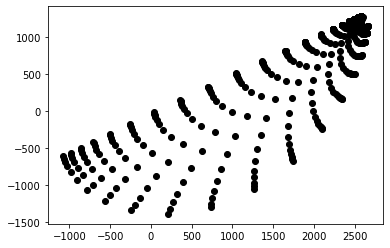

In [12]:
# aquarium properties
water_conductivities_id   = 0 
boundary_normals_id       = 0
boundary_displacements_id = 0
# fish properties
tail_lateral_angle_id    = 0
tail_dor_ven_angle_id    = 0
tail_location_percent_id = 0
fish_yaw_id              = 0
fish_pitch_id            = 0
fish_roll_id             = 0
# worm properties
worm_radii_id   = 0
worm_xs_id      = 0
worm_ys_id      = 0
worm_zs_id      = 0

# select receptor
worm_position = np.array([worm_xs[worm_xs_id], worm_ys[worm_ys_id], worm_zs[worm_zs_id]])
receptors = fish_objs[base_EI_id].get_receptors_locations()
receptor_id = np.linalg.norm(receptors - worm_position, axis=1).argmin()

conv_feat0 = []
conv_feat1 = []
for res_id in range(len(resistances)):
    print(res_id, end=': ')
    for cap_id in range(len(capacitances)):
        print(cap_id, end=' ')

        base_EI_id, pert_EI_id = find_EI_ids(properties_ids_base, properties_ids_pert, properties_dict,
                water_conductivities_id, boundary_normals_id, boundary_displacements_id, tail_lateral_angle_id, tail_dor_ven_angle_id, tail_location_percent_id, fish_yaw_id, fish_pitch_id, fish_roll_id,
                res_id, cap_id, 
                worm_radii_id, worm_xs_id, worm_ys_id, worm_zs_id,
                # default_boundary_displacement_id=0, default_tail_lateral_angle_id=4, default_tail_dor_ven_angle_id=0, default_yaw_id=0, default_pitch_id=0, default_roll_id=0,
                default_boundary_displacement_id=0, default_tail_lateral_angle_id=0, default_tail_dor_ven_angle_id=0, default_yaw_id=0, default_pitch_id=0, default_roll_id=0,
                cancel_boundary=False,
                cancel_tail=False,
                cancel_rotation=False)
        
        conv_feat0.append(pert_EI[pert_EI_id, receptor_id, 0] -  base_EI[base_EI_id, receptor_id, 0])
        conv_feat1.append(pert_EI[pert_EI_id, receptor_id, 1] -  base_EI[base_EI_id, receptor_id, 1])
        
    print()

plt.figure()
plt.scatter(conv_feat0, conv_feat1, c='k')
plt.show()

In [13]:
worm_position, receptors[receptor_id], receptor_id

(array([-0.035,  0.017,  0.   ]),
 array([-0.03413793,  0.007     ,  0.        ]),
 9)

# Check Feature Space

In [16]:
idx = (
    (properties_ids_pert[:,properties_dict['water_conductivity']] == 0) & 
    (properties_ids_pert[:,properties_dict['boundary_normals']] == 0) &
    (properties_ids_pert[:,properties_dict['boundary_displacements']] == 0) & 
    # (properties_ids_pert[:,properties_dict['tail_lateral_angle']] == 6) & 
    (properties_ids_pert[:,properties_dict['tail_lateral_angle']] == 0) & 
    (properties_ids_pert[:,properties_dict['tail_dor_ven_angle']] == 0) & 
    (properties_ids_pert[:,properties_dict['tail_location_percent']] == 0) & 
    (properties_ids_pert[:,properties_dict['fish_yaw']] == 0) & 
    (properties_ids_pert[:,properties_dict['fish_pitch']] == 0) & 
    (properties_ids_pert[:,properties_dict['fish_roll']] == 0) & 
    # (properties_ids_pert[:,properties_dict['resistances']] == resistances_id) & 
    # (properties_ids_pert[:,properties_dict['resistances']] % 1 == 0) & 
    # (properties_ids_pert[:,properties_dict['capacitances']] == capacitances_id) & 
    # (properties_ids_pert[:,properties_dict['capacitances']] % 1 == 0) & 
    (properties_ids_pert[:,properties_dict['worm_radii']] == 2) & 
    (properties_ids_pert[:,properties_dict['worm_xs']] == 1) & 
    # (properties_ids_pert[:,properties_dict['worm_ys']] == 0) & 
    (properties_ids_pert[:,properties_dict['worm_zs']] == 0), 
)[0]

relevant_ids = properties_ids_pert[idx, properties_dict['pert_EI']]
distances = worm_ys[properties_ids_pert[idx, properties_dict['worm_ys']]] - 0.007
relevant_EIs = pert_EI[relevant_ids] - base_EI[base_EI_id]
temp1, temp2 = np.unique(np.abs(relevant_EIs).argmax(1), return_counts=True)
print(temp1[temp2.argmax()], temp1, temp2)
relevant_feats = relevant_EIs[:,temp1[temp2.argmax()]]
receptors_loc = fish_objs[base_EI_id].get_receptors_locations().copy()
print(receptors_loc[temp1[temp2.argmax()]])  #, worm_position)

194 [194] [3750]
[-0.01118802  0.00683278 -0.00115979]


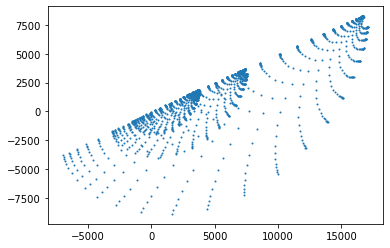

In [17]:
plt.scatter(*relevant_feats.T, s=1)
plt.show()

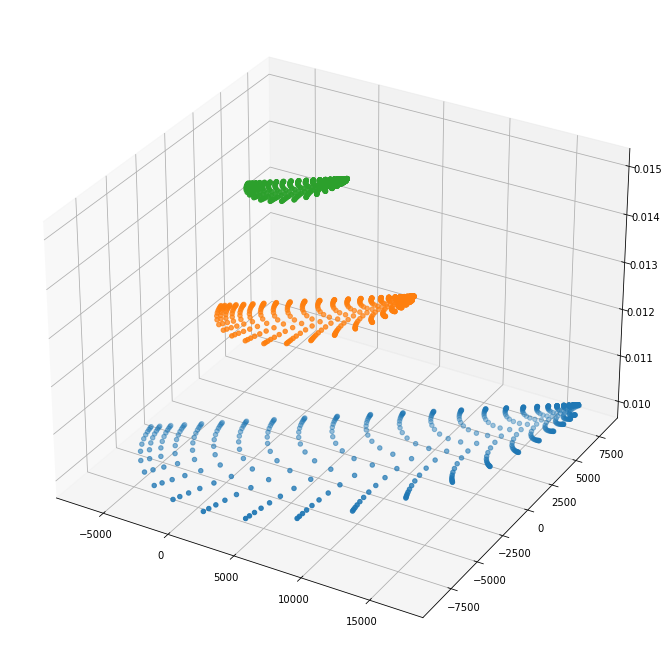

In [18]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(relevant_feats[:,0], relevant_feats[:,1], distances, c=[f'C{i}' for i in properties_ids_pert[idx, properties_dict['worm_ys']]])
plt.show()

In [ ]:
properties_ids_base[
    (properties_ids_base[:,properties_dict['water_conductivity']] == properties_ids_pert[:1000, properties_dict['water_conductivity']]) & 
    (properties_ids_base[:,properties_dict['boundary_displacements']] == properties_ids_pert[:1000, properties_dict['boundary_displacements']]) & 
    (properties_ids_base[:,properties_dict['tail_lateral_angle']] == properties_ids_pert[:1000, properties_dict['tail_lateral_angle']]),
    -1
]

## Repair Generated Data

In [ ]:
# #############################
# REPAIR_ID_NUMBER = 3
# #############################

# file_name = '../data/processed/needs_repair_data_220610_Large_dataset_with_receptors_responses'
# use_torch = False
# find_base_id_for_each_EI=False

# [properties_dict,
# properties_ids_base, properties_ids_pert,
# base_EI, base_LEODs, pert_EI, pert_LEODs,
# # aquarium properties
# water_conductivities, boundary_normals, boundary_displacements,
# # fish properties
# tail_lateral_angle, tail_dor_ven_angle, tail_location_percent, fish_yaw, fish_pitch, fish_roll,
# # worm properties
# resistances, capacitances, worm_radii, worm_xs, worm_ys, worm_zs,
# # statistics of receptor responses
# receptors_avg, receptors_std,
# # objects used in simulations
# aqua_objs, fish_objs, worm_objs] = \
#     load_data_full(file_name=file_name, use_torch=use_torch, find_base_id_for_each_EI=find_base_id_for_each_EI)
    
# print(properties_ids_base.shape)
# print(properties_ids_pert.shape)
# file_name_repair = f'../data/processed/repair_{REPAIR_ID_NUMBER}'
# use_torch_repair = False
# find_base_id_for_each_EI_repair=False

# [properties_dict_repair,
# properties_ids_base_repair, properties_ids_pert_repair,
# base_EI_repair, base_LEODs_repair, pert_EI_repair, pert_LEODs_repair,
# # aquarium properties
# water_conductivities_repair, boundary_normals_repair, boundary_displacements_repair,
# # fish properties
# tail_lateral_angle_repair, tail_dor_ven_angle_repair, tail_location_percent_repair, fish_yaw_repair, fish_pitch_repair, fish_roll_repair,
# # worm properties
# resistances_repair, capacitances_repair, worm_radii_repair, worm_xs_repair, worm_ys_repair, worm_zs_repair,
# # statistics of receptor responses
# receptors_avg_repair, receptors_std_repair,
# # objects used in simulations
# aqua_objs_repair, fish_objs_repair, worm_objs_repair] = \
#     load_data_full(file_name=file_name_repair, use_torch=use_torch_repair, find_base_id_for_each_EI=find_base_id_for_each_EI_repair)
    
# print(properties_ids_base_repair.shape)
# print(properties_ids_pert_repair.shape)
# f = h5py.File('../data/processed/data_220610_Large_dataset_with_receptors_responses.hdf5', 'r+')
# if REPAIR_ID_NUMBER == 1:
#     wat_id = 2
#     cap_id = 24
#     res_id = 15
# elif REPAIR_ID_NUMBER == 2:
#     wat_id = 1
#     cap_id = 24
#     res_id = 13
# elif REPAIR_ID_NUMBER == 3:
#     wat_id = 1
#     cap_id = 23
#     res_id = 17
# else:
#     raise ValueError('ERROR!')
# for i in np.arange(0, properties_ids_pert_repair.shape[0], 500):
#     print(i, end=', ')
#     temp_pert_ids = properties_ids_pert_repair.copy()
#     temp_pert_ids[:, properties_dict['water_conductivity']] = wat_id
#     temp_pert_ids[:, properties_dict['capacitances']] = cap_id
#     temp_pert_ids[:, properties_dict['resistances']] += res_id
#     temp_pert_ids_orig = properties_ids_pert[properties_ids_pert[:,0] == wat_id].copy()
#     star_pert_id = np.where(properties_ids_pert[:,0] == wat_id)[0][0]
#     repair_ids = (temp_pert_ids_orig[:,np.newaxis,:-2].astype(np.int8) == temp_pert_ids[np.newaxis,i:(i+500),:-2].astype(np.int8)).all(-1)
#     repair_ids = np.where(repair_ids)
#     f['pert_EI'][repair_ids[0] + star_pert_id] = pert_EI_repair[repair_ids[1]+i]
# f.close()

In [ ]:
# # repair_1
# water_id = 2
# cap_id  = 24
# res_ids = 15 - 24

# # repair_2
# water_id = 1
# cap_id  = 24
# res_ids = 13 - 24

# # repair_3
# water_id = 1
# cap_id  = 23
# res_ids = 17 - 24

# water_id = 1
# res_id = 15
# cap_id = 23
# temp = np.where(((properties_ids_pert[:,0] == water_id) & (properties_ids_pert[:,9] == res_id) & (properties_ids_pert[:,10] == cap_id)))[0]
# rand_ids = temp[np.random.permutation(temp.shape[0])[:100]]
# rand_ids = rand_ids[rand_ids.argsort()]
# max_err = 0 
# for i, v in enumerate(rand_ids):
#     temp_pert_data = pert_EI[v]
#     temp_id_base = (properties_ids_base[:,:-1] == properties_ids_pert[v,:properties_ids_base.shape[1]-1]).sum(-1).argmax()
#     temp_base_data = base_EI[temp_id_base]
#     current_err = np.abs(temp_base_data - temp_pert_data).max()
#     if current_err > max_err:
#         max_err = current_err
# max_err